# MSP projekt 2 - Ondřej Lukášek (xlukas15)

Začnu tím, že si naimportuji potřebné knihovny, se kterými budu v projektu pracovat.

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as stats
import scipy.special as special
import statsmodels.formula.api as smf

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot

## Úkol 1 - Věrohodnost

Nejprve si načtu list (sheet), který obsahuje data, se kterými budu pracovat.

Předpřipravím si parametry tak, abych je později mohl rovnou použít.

In [68]:
file_path = 'Data_2024.xlsx'
sheet_name = 'Data_věrohodnost'

data = pd.read_excel(file_path, sheet_name=sheet_name)
times = data['doba práce v oboru [roky]'].dropna().to_numpy()
censored = data['censored'].to_numpy()

initial_params = (1.5, 5.0)

### 1.1

Zapište zvolenou parametrizaci Weibullova rozdělení, logaritmickou-věrohodnostní funkci pro zadaná data a její parciální derivace podle parametrů (shape, scale).

**Funkce hustoty pravděpodobnosti Weibullova rozdělení vypadá takto (vizte stránku na [Wikipedii](https://en.wikipedia.org/wiki/Weibull_distribution)):**

$ f(x; k, \lambda) = \frac{k}{\lambda} \left(\frac{x}{\lambda}\right)^{k-1} e^{-(\frac{k}{\lambda})^k}, \quad x \geq 0 $

---

**Log-likelihood potom je:**

$ \ell(k, \lambda) = \sum_{i=1}^n (1 - c_i) \left[\ln k - k \ln \lambda + (k - 1) \ln x_i - \left(\frac{x_i}{\lambda}\right)^k\right] + c_i \left[-\left(\frac{x_i}{\lambda}\right)^k\right] $

přičemž:

- $ x_i $ je "time-to-failure",
- $ c_i $ značí cenzorovanost daného data (`True/False`).

---

**Parciální derivace pak jsou:**

*Podle $ k $:*

$ \frac{\partial \ell}{\partial k} = \sum_{i=1}^n (1 - c_i) \left[\frac{1}{k} + \ln \frac{x_i}{\lambda} - \left(\frac{x_i}{\lambda}\right)^k \ln \frac{x_i}{\lambda}\right] + c_i \left[-\left(\frac{x_i}{\lambda}\right)^k \ln \frac{x_i}{\lambda}\right] $

*Podle $ \lambda $:*

$ \frac{\partial \ell}{\partial \lambda} = \sum_{i=1}^n (1 - c_i) \left[-\frac{k}{\lambda} + k \left(\frac{x_i}{\lambda}\right)^k \frac{1}{\lambda}\right] + c_i \left[k \left(\frac{x_i}{\lambda}\right)^k \frac{1}{\lambda}\right] $

In [69]:
def weibull_log_likelihood(params, times, censored):
    k, lam = params
    
    # logaritmizace pro necenzurovana data
    log_f = np.log(k) - k * np.log(lam) + (k - 1) * np.log(times) - (times / lam)**k
    # logaritmizace pro cenzurovana data
    log_sf = - (times / lam)**k
    
    # spojeni logaritmu pro necenzurovana a cenzurovana data
    likelihood = (1 - censored) * log_f + censored * log_sf

    return likelihood.sum()


# MOZNA SMAZAT???
def weibull_log_likelihood_derivatives(params, times, censored):
    k, lam = params

    # predvypocitani konstant, co se budou v derivacich opakovat
    t_lam_k = (times / lam)**k
    log_t_lam = np.log(times / lam)
    
    # parcialni derivace logaritmu podle parametru k
    dL_dk = np.sum((1 - censored) * (1 / k + log_t_lam - t_lam_k * log_t_lam) + censored * (-t_lam_k * log_t_lam))
    # parcialni derivace logaritmu podle parametru lambda
    dL_dlam = np.sum((1 - censored) * (-k / lam + k * t_lam_k / lam) + censored * (k * t_lam_k / lam))
    
    return np.array([dL_dk, dL_dlam])


log_likelihood = weibull_log_likelihood(initial_params, times, censored)
derivatives = weibull_log_likelihood_derivatives(initial_params, times, censored)

print(f'Log-likelihood: {log_likelihood}')
print(f'Derivatives: {derivatives}')

Log-likelihood: -740.8976732574417
Derivatives: [64.24195393 77.00791218]


### 1.2

Pomocí `scipy.optimize` nalezněte maximálně věrohodné odhady parametrů weibullova rozdělení.

In [70]:
# optimize ma jenom minimize, proto musim dat minus
def neg_weibull_log_likelihood(params, times, censored):
    return -weibull_log_likelihood(params, times, censored)


# vypocitam optimalni parametry
result = opt.minimize(
    fun=neg_weibull_log_likelihood,
    x0=initial_params,
    args=(times, censored),
    method='L-BFGS-B',
    bounds=[(0.1, None), (0.1, None)]
)

optimal_shape, optimal_scale = result.x

print('Maximal likelihood estimation:')
print(f'Shape (k): {optimal_shape}')
print(f'Scale (lambda): {optimal_scale}')

Maximal likelihood estimation:
Shape (k): 6.172808847674017
Scale (lambda): 7.4294603426242265


### 1.3

Pomocí věrohodnostního poměru otestujte hypotézu, že exponenciální rozdělení je postačujícím modelem zapsaných dat (Parametr tvaru = 1).

By default je distribuční funkce (pro $ x \geq 0 $) exponenciálního rozdělení:

$ f(x; \lambda) = \lambda e^{-\lambda x} $

Logaritmus potom bude:

$ \ell(x; \lambda) = \ln \lambda - \lambda x $

Log-likelihood potom je:

$ \ell(\lambda) = \sum_{i=1}^n \left[ \ln \lambda - \lambda x_i \right]  $

In [71]:
# napisu si likelihood exponencialniho rozlozeni
def exponential_log_likelihood(lam, times, censored):
    log_f = np.log(lam) - lam * times
    log_sf = -lam * times

    likelihood = (1 - censored) * log_f + censored * log_sf
    return np.sum(likelihood)


# maximalni likelihood pro exponencialni rozlozeni
result_exp = opt.minimize(
    fun=lambda lam: -exponential_log_likelihood(lam[0], times, censored),
    x0=[1.0],
    bounds=[(0.1, None)],
    method='L-BFGS-B'
)

lambda_exp = result_exp.x[0]
log_likelihood_exp = -result_exp.fun

k_weibull, lambda_weibull = result.x
result_weibull = -result.fun

# VYPOCET VEROHODNOSTNIHO POMERU
LR = 2 * (result_weibull - log_likelihood_exp)

alpha = 0.05
critical_value = stats.chi2.ppf(1 - alpha, df=1)

print(f'Likelihood ratio: {LR}')
print(f'Critical value (alpha = {alpha}): {critical_value}')

if LR > critical_value:
    print('Zamítáme nulovou hypotézu. Exponenciální rozdělení není postačující.')
else:
    print('Nulovou hypotézu nezamítáme. Exponenciální rozdělení je postačující.')

Likelihood ratio: 592.3898153427439
Critical value (alpha = 0.05): 3.841458820694124
Zamítáme nulovou hypotézu. Exponenciální rozdělení není postačující.


### 1.4

Podle výsledku z předchozího bodu použijte výsledné rozdělení pravděpodobnosti (s maximálně věrohodnými odhady jako parametry) a nalezněte bodové odhady pro střední dobu zaměstnání v oboru a 10% percentil zaměstnání v oboru (za jakou dobu odejde do jiného oboru 10% absolventů).

Jelikož v předchozím bodu na základě testu vyšlo, že exponenciální rozdělení není postačující, budu dále pokračovat s Weibullovým rozdělením.

U Weibullova rozdělení se střední hodnota vypočítá následovně (z Wikipedie):

$ Mean = \lambda \Gamma (1 + \frac{1}{k}) $

A kvantily se počítají pomocí vzorce:

$ Q(p) = \lambda (- \ln (1 - p))^{\frac{1}{k}} \implies Q(0.1) = \lambda (- \ln (0.9))^{\frac{1}{k}} $

In [72]:
# stredni hodnota weiibullova rozlozeni
def weibull_mean(k, lam):
    return lam * special.gamma(1 + 1 / k)


# kvantil weiibullova rozlozeni
def weibull_quantile(p, k, lam):
    return lam * (- np.log(1 - p))**(1 / k)


mean = weibull_mean(k_weibull, lambda_weibull)
quantile = weibull_quantile(0.1, k_weibull, lambda_weibull)

print('=== Weibull distribution ===')
print(f'Shape (k): {k_weibull}')
print(f'Scale (lambda): {lambda_weibull}\n')

print('=== Mean, Quantile ===')
print(f'Mean: {mean}')
print(f'10% quantile: {quantile}')

=== Weibull distribution ===
Shape (k): 6.172808847674017
Scale (lambda): 7.4294603426242265

=== Mean, Quantile ===
Mean: 6.903242509050911
10% quantile: 5.159769490910647


### 1.5 (dobrovolný)

Zkuste nějak slovně charakterizovat/popsat fungování doby zaměstnání v oboru jako náhodné veličiny, dle vašich výsledků a parametrů.

**TODO**

## Úkol 2 - Regrese

Opět začnu tím, že si nejprve načtu data z Excelu. Pro jistotu si přetypuji hodnoty. 

In [73]:
file_path = 'Data_2024.xlsx'
sheet_name = 'Data_regrese'

df = pd.read_excel(file_path, sheet_name=sheet_name)

df['OSType'] = df['OSType'].astype('category')

columns_to_numeric = ['ActiveUsers', 'InteractingPct', 'ScrollingPct', 'Ping [ms]']
df[columns_to_numeric] = df[columns_to_numeric].apply(pd.to_numeric, errors='coerce')

# prejmenuji si sloupcek Ping [ms] na Ping
df.rename(columns={'Ping [ms]': 'Ping'}, inplace=True)

df.head()

,OSType,ActiveUsers,InteractingPct,ScrollingPct,Ping
0,iOS,4113,0.8283,0.1717,47
1,iOS,7549,0.3461,0.6539,46
2,Windows,8855,0.2178,0.7822,55
3,Android,8870,0.0794,0.9206,56
4,MacOS,9559,0.7282,0.2718,76


Nyní si znormalizuji hodnoty pro sloupec aktivních uživatelů.

In [74]:
# udelam si kopii, abych mohl potom denormalizovat
df_original = df.copy()

# provedu normalizaci na <-1, 1>
df['ActiveUsers'] = 2 * (df['ActiveUsers'] - (df['ActiveUsers'].max() + df['ActiveUsers'].min()) / 2) / (df['ActiveUsers'].max() - df['ActiveUsers'].min())

df.head()

,OSType,ActiveUsers,InteractingPct,ScrollingPct,Ping
0,iOS,-0.191837,0.8283,0.1717,47
1,iOS,0.509388,0.3461,0.6539,46
2,Windows,0.775918,0.2178,0.7822,55
3,Android,0.778980,0.0794,0.9206,56
4,MacOS,0.919592,0.7282,0.2718,76


Připravím si i funkci pro denormalizaci, protože bych ji mohl potřebovat (spoiler: budu ji potřebovat).

In [75]:
def denormalize_value(value):
    global df_original

    min_active = df_original['ActiveUsers'].min()
    max_active = df_original['ActiveUsers'].max()

    denormalized_value = value * (max_active - min_active) / 2 + (max_active + min_active) / 2

    return denormalized_value

Vytvořím si dummy sloupečky pro operační systémy tak, že každý OS bude mít svůj sloupeček (kromě Androidu, ten je reference).
Hodnoty ve sloupečcích OS mohou nabývat hodnoty `True` nebo `False`.

In [76]:
# prevod na dummy promenne - Android dropneme, protoze bude refencni kategorii
dummy_ostype = pd.get_dummies(df['OSType'], drop_first=True)

# sloucime je s puvodnim dataframem a dropneme puvodni sloupec, protoze neni potreba
df = pd.concat([df, dummy_ostype], axis=1)
df = df.drop(columns=['OSType'])

print(df.head())

   ActiveUsers  InteractingPct  ScrollingPct  Ping  MacOS  Windows    iOS
0    -0.191837          0.8283        0.1717    47  False    False   True
1     0.509388          0.3461        0.6539    46  False    False   True
2     0.775918          0.2178        0.7822    55  False     True  False
3     0.778980          0.0794        0.9206    56  False    False  False
4     0.919592          0.7282        0.2718    76   True    False  False


### 2.1

Pomocí zpětné eliminace určete vhodný regresní model. Za výchozí "plný" model považujte plný kvadratický model (všechny interakce druhého řádu a všechny druhé mocniny, které dávají smysl).

- Zapište rovnici Vašeho finálního modelu.
- Diskutujte splnění přepokladů lineární regrese a základní regresní diagnostiky.
- Pokud (až během regresního modelování) identifikujete některé "nejodlehlejší" hodnoty, po alespoň krátkém zdůvodnění, vyřadit.

Začnu tím, že si data vizualizuji pro lepší představu toho, s čím budu vlastně pracovat.

Zřejmě budu pracovat se závislostí odezvy na počtu aktivní uživatelů na mé sociální síti.

Na grafu je možné si pouhým okem všimnout rostoucí tendence - tedy čím víc je uživatelů, tím větší je ping.


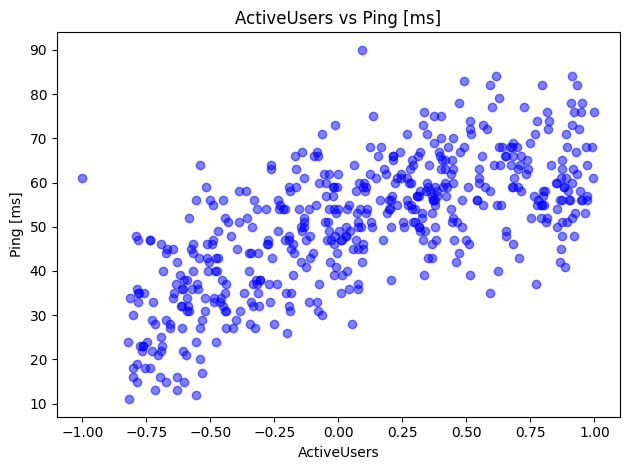

In [77]:
# ActiveUsers vs Ping [ms]
plt.scatter(df['ActiveUsers'], df['Ping'], alpha=0.5, color='blue')
plt.title('ActiveUsers vs Ping [ms]')
plt.xlabel('ActiveUsers')
plt.ylabel('Ping [ms]')


plt.tight_layout()
plt.show()

Teďka už můžu vytvořit formuli, která bude na začátku vypadat takto:

$   formule = 
    \beta_{0} +
    \beta_{1} \cdot ActiveUsers + \beta_{2} \cdot InteractingPct + \beta_{3} \cdot ScrollingPct + \beta_{4} \cdot MacOS + \beta_{5} \cdot Windows + \beta_{6} \cdot iOS +
    \beta_{7} \cdot ActiveUsers^2 + \beta_{8} \cdot ActiveUsers \cdot InteractingPct + \beta_{9} \cdot ActiveUsers \cdot ScrollingPct + \beta_{10} ActiveUsers \cdot MacOS + \beta_{11} \cdot ActiveUsers \cdot Windows + \beta_{12} ActiveUsers \cdot iOS +
    \beta_{13} \cdot InteractingPct^2 + \beta_{14} \cdot InteractingPct \cdot ScrollingPct + \beta_{15} \cdot InteractingPct \cdot MacOS + \beta_{16} \cdot InteractingPct \cdot Windows + \beta_{17} \cdot InteractingPct \cdot iOS +
    \beta_{18} \cdot ScrollingPct^2 + \beta_{19} \cdot ScrollingPct \cdot MacOS + \beta_{20} \cdot ScrollingPct \cdot Windows + \beta_{21} \cdot ScrollingPct \cdot iOS
$

In [78]:
formula = (
    'Ping ~ ActiveUsers + InteractingPct + ScrollingPct + MacOS + Windows + iOS +'
    'I(ActiveUsers**2) + ActiveUsers:InteractingPct + ActiveUsers:ScrollingPct + ActiveUsers:MacOS + ActiveUsers:Windows + ActiveUsers:iOS +'
    'I(InteractingPct**2) + InteractingPct:ScrollingPct + InteractingPct:MacOS + InteractingPct:Windows + InteractingPct:iOS +'
    'I(ScrollingPct**2) + ScrollingPct:MacOS + ScrollingPct:Windows + ScrollingPct:iOS'
)

def evaluate_model(df, formula):
    model = smf.ols(formula=formula, data=df)
    result = model.fit()
    return result, model

result, model = evaluate_model(df, formula)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        20:56:08   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [79]:
X = pd.DataFrame(model.exog, columns=model.exog_names)
vif = pd.Series([variance_inflation_factor(X.values, i)
                 for i in range(X.shape[1])],
                 index=X.columns)
vif_df = vif.to_frame()

vif_df.columns = ['VIF']
print('====  VIF ====')
print(vif_df)

print('\n\n\n==== Matice korelace ====')
print(X.corr())


====  VIF ====
                                     VIF
Intercept                       0.000000
MacOS[T.True]                        inf
Windows[T.True]                      inf
iOS[T.True]                          inf
ActiveUsers                          inf
ActiveUsers:MacOS[T.True]       2.385958
ActiveUsers:Windows[T.True]     2.434729
ActiveUsers:iOS[T.True]         2.231460
InteractingPct                       inf
InteractingPct:MacOS[T.True]         inf
InteractingPct:Windows[T.True]       inf
InteractingPct:iOS[T.True]           inf
ScrollingPct                         inf
ScrollingPct:MacOS[T.True]           inf
ScrollingPct:Windows[T.True]         inf
ScrollingPct:iOS[T.True]             inf
I(ActiveUsers ** 2)             1.145080
ActiveUsers:InteractingPct           inf
ActiveUsers:ScrollingPct             inf
I(InteractingPct ** 2)               inf
InteractingPct:ScrollingPct          inf
I(ScrollingPct ** 2)                 inf



==== Matice korelace ====
             

C:\Users\ondre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\ondre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Na výsledku si lze všimnout, že některé hodnoty VIFu jsou `> 10`.

Vytvořím si ještě matici korelace, abych zjistil, kde se nacházejí závislosti, které mi tvoří problémy s vytvořením modelu.

Zjišťuji, že problém tvoří korelace mezi `ScrollingPct` a `InteractingPct`.
Dává to i smysl, vzhledem k tomu, že hodnoty si jsou doplňky, protože se jedná o procentuální hodnoty.
Zbavit se tedy nejspíš mohu jedné z nich a je jedno které. Zkusím se zbavit `InteractingPct` a výpočet VIFu provedu znovu.

In [80]:
formula = (
    'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + iOS +'
    'I(ActiveUsers**2) + ActiveUsers:InteractingPct + ActiveUsers:MacOS + ActiveUsers:Windows + ActiveUsers:iOS +'
    'I(InteractingPct**2) + InteractingPct:MacOS + InteractingPct:Windows + InteractingPct:iOS'
)

result, model = evaluate_model(df, formula)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        20:56:08   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Formuli jsem upravil tak, abych z ní vyškrtl `ScrollingPct`, teď zkusím znovu přepočítat VIFy.

In [81]:
X = pd.DataFrame(model.exog, columns=model.exog_names)
vif = pd.Series([variance_inflation_factor(X.values, i)
                 for i in range(X.shape[1])],
                 index=X.columns)
vif_df = vif.to_frame()

vif_df.columns = ['VIF']
print('====  VIF ====')
print(vif_df)

====  VIF ====
                                      VIF
Intercept                       23.383991
MacOS[T.True]                    6.272004
Windows[T.True]                  6.417808
iOS[T.True]                      5.723560
ActiveUsers                      7.817225
ActiveUsers:MacOS[T.True]        2.385958
ActiveUsers:Windows[T.True]      2.434729
ActiveUsers:iOS[T.True]          2.231460
InteractingPct                  20.191723
InteractingPct:MacOS[T.True]     7.586537
InteractingPct:Windows[T.True]   6.857633
InteractingPct:iOS[T.True]       6.028016
I(ActiveUsers ** 2)              1.145080
ActiveUsers:InteractingPct       3.872128
I(InteractingPct ** 2)          16.060875


Nyní už vycházejí všechny hodnoty VIFu `< 10`, což je přijatelné. Můžu se tedy přesunout k zpětné eliminaci.

To znamená, že teď budu potřebovat, aby všechny hodnoty ve sloupci `P > |t|` byly menší, než jaký je můj nastavený práh. Ten bude nastaven na klasických `5%`, tedy `0.05`.

Toho docílím tak, že postupně budu odstraňovat největší členy formule a sledovat, jak se model změní při postupných změnách.
V tuto chvíli je největší hodnota `InteractingPct:iOS[T.True]` s hodnotou `0.921`.
Smažu tedy tento člen.

In [82]:
formula = (
    'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + iOS +'
    'I(ActiveUsers**2) + ActiveUsers:InteractingPct + ActiveUsers:MacOS + ActiveUsers:Windows + ActiveUsers:iOS +'
    'I(InteractingPct**2) + InteractingPct:MacOS + InteractingPct:Windows'
)

result, model = evaluate_model(df, formula)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     202.8
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          3.58e-187
Time:                        20:56:08   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3225.
Df Residuals:                     488   BIC:                             3284.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

První člen byl odstraněn, nicméně je potřeba pracovat dále. Nyní je největším členem `InteractingPct:Windows[T.True]` s hodnotou `0.902`.
Tak jej odstraníme a opět vyhodnotíme.

In [83]:
formula = (
    'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + iOS +'
    'I(ActiveUsers**2) + ActiveUsers:InteractingPct + ActiveUsers:MacOS + ActiveUsers:Windows + ActiveUsers:iOS +'
    'I(InteractingPct**2) + InteractingPct:MacOS'
)

result, model = evaluate_model(df, formula)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     220.1
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          2.38e-188
Time:                        20:56:08   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3223.
Df Residuals:                     489   BIC:                             3278.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

Stále jsou zde členy, které je potřeba zmenšit. Nyní to bude `InteractingPct:MacOS[T.True]` s hodnotou `0.760`.

In [84]:
formula = (
    'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + iOS +'
    'I(ActiveUsers**2) + ActiveUsers:InteractingPct + ActiveUsers:MacOS + ActiveUsers:Windows + ActiveUsers:iOS +'
    'I(InteractingPct**2)'
)

result, model = evaluate_model(df, formula)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     240.6
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          1.57e-189
Time:                        20:56:08   Log-Likelihood:                -1598.5
No. Observations:                 502   AIC:                             3221.
Df Residuals:                     490   BIC:                             3272.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Opět vyhodnoceno, ale stále zbývá člen `I(InteractingPct ** 2)` s hodnotou `0.278`, který je potřeba odstranit.

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     264.4
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          1.69e-190
Time:                        20:56:08   Log-Likelihood:                -1599.1
No. Observations:                 502   AIC:                             3220.
Df Residuals:                     491   BIC:                             3267.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

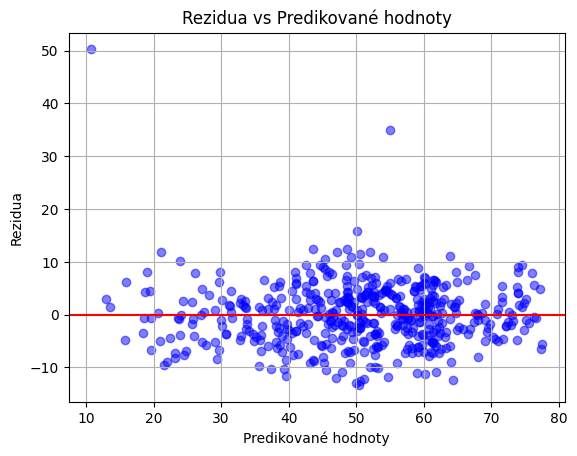

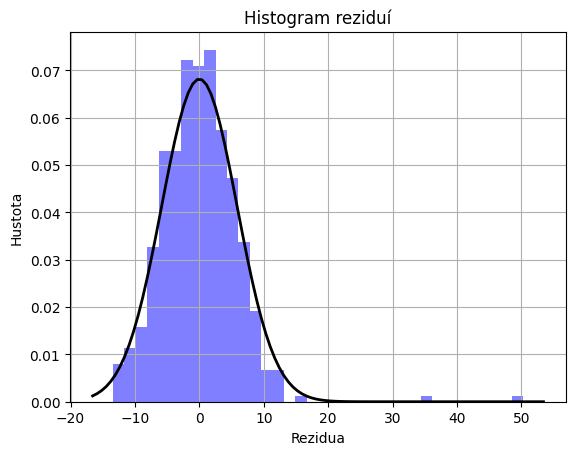

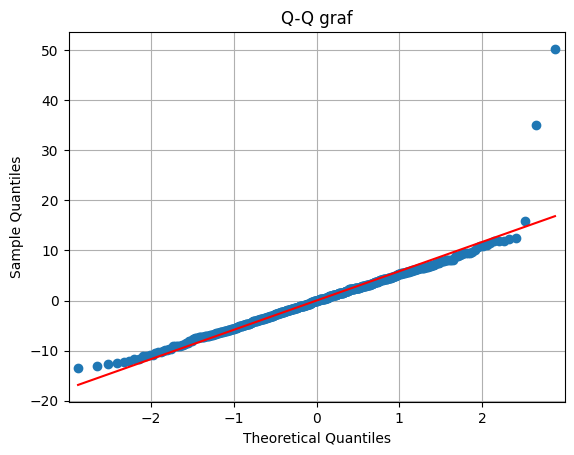

In [85]:
formula = (
    'Ping ~ ActiveUsers + InteractingPct + MacOS + Windows + iOS +'
    'I(ActiveUsers**2) + ActiveUsers:InteractingPct + ActiveUsers:MacOS + ActiveUsers:Windows + ActiveUsers:iOS'
)

result, model = evaluate_model(df, formula)
print(result.summary())

# REZIDUA VS PREDIKOVANE HODNOTY
plt.scatter(result.fittedvalues, result.resid, alpha=0.5, color='blue')

plt.axhline(y=0, color='r', linestyle='-') 
plt.grid(True)
plt.xlabel('Predikované hodnoty')
plt.ylabel('Rezidua')
plt.title('Rezidua vs Predikované hodnoty')
plt.show()

# HISTOGRAM REZIDUI
plt.hist(result.resid, bins='auto', color='blue', alpha=0.5, density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(result.resid), np.std(result.resid))
plt.plot(x, p, 'k', linewidth=2)
plt.grid(True)
plt.title("Histogram reziduí")
plt.xlabel("Rezidua")
plt.ylabel("Hustota")
plt.show()

# Q-Q GRAF
qqplot(result.resid, line='s')
plt.title('Q-Q graf')
plt.grid(True)
plt.show()

Poslední úprava mě dostala ke zdárnému výsledku. Žádný z členů formule mi nepřesahuje hodnotu `0.05`, přičemž největší z nich je `ActiveUsers:Windows[T.True]` s hodnotou `0.015`, což je v pořádku.

Finální formule tedy vypadá takto:

$ 
    formula = 
    \beta_{0} +
    \beta_{1} \cdot ActiveUsers + \beta_{2} \cdot InteractingPct + \beta_{3} \cdot MacOS + \beta_{4} \cdot Windows + \beta_{5} \cdot iOS +
    \beta_{6} \cdot ActiveUsers^2 + \beta_{7} \cdot ActiveUsers \cdot InteractingPct + \beta_{8} \cdot ActiveUsers \cdot MacOS + \beta_{9} \cdot ActiveUsers \cdot Windows + \beta_{10} \cdot ActiveUsers \cdot Windows
$

**Rovnice modelu**

Rovnice modelu tedy bude vypadat následovně:

$ 
    model = 
    40.2495 +
    24.4186 \cdot ActiveUsers + 18.3647 \cdot InteractingPct + 8.7999 \cdot MacOS + 4.1936 \cdot Windows - 5.3112 \cdot iOS -
    9.9907 \cdot ActiveUsers^2 - 15.1484 \cdot ActiveUsers \cdot InteractingPct + 6.9549 \cdot ActiveUsers \cdot MacOS - 3.6108 \cdot ActiveUsers \cdot Windows - 5.0588 \cdot ActiveUsers \cdot Windows
$

**Diskuze splnění předpokladů lineární regrese**

Model má velice poměrně dobrou hodnotu **R-squared** (`0.843`), díky čemuž by měl být schopný solidně predikovat ping.

Výsledek **Durbin-Wattsonova** testu vyšel `1.928`, což znamená, že rezidua nejsou autokorelovaná, takže jejich závislost není problémem.

Problém je ovšem výsledek **Jarque-Berra** testu (`0.0`), podle kterého rezidua nejsou normálně rozložena.
To v poměrně viditelně ukazuje i histogram reziduí výše.
Je možné, že dělají problém odlehlé hodnoty, které teď mohou dost ovlivňovat přesnost modelu (spoiler: je to pravda).

Celkově by tedy model nebyl vůbec špatný, nicméně se v dalším bodu níže zaměřím na problém s outliery.

**Zbavení se odlehlých hodnot**

In [86]:
influence = result.get_influence()
# Leverage
leverage = influence.hat_matrix_diag
# Cookovy D hodnoty (a p-hodnoty) jako n-tice polí [n x 2]
cooks_d = influence.cooks_distance
# Standardizovaná rezidua
standardized_residuals = influence.resid_studentized_internal
# Studentizovaná rezidua
studentized_residuals = influence.resid_studentized_external
# Výpočet p-hodnot pro studentizovaná rezidua
studentized_residuals_pvalues = 2 * (1 - stats.t.cdf(np.abs(studentized_residuals), df=df.shape[0]-len(result.params)))

#tabulka dohromady dořešit změny počtu řádků
outl_stats_df = pd.DataFrame({
    'Leverage': leverage,
    'Standardized Residuals': standardized_residuals,
    'Studentized Residuals': studentized_residuals,
    'Studentized Residuals p-value': studentized_residuals_pvalues,
    'Cook\'s Distance': cooks_d[0],
    'Cook\'s Distance_p-value': cooks_d[1]
}, index=df.index)
#vyber jen "zajímavý" hodnoty
outl_stats_df = outl_stats_df[(outl_stats_df['Leverage'] > 3*len(result.params)/df.shape[0]) | (np.abs(outl_stats_df['Standardized Residuals']) > 2) | (outl_stats_df['Cook\'s Distance_p-value'] < 0.05)]

summary_frame = influence.summary_frame()

print(outl_stats_df)

     Leverage  Standardized Residuals  Studentized Residuals  \
62   0.012590               -2.036977              -2.043554   
82   0.010646                2.699228               2.716710   
114  0.012955                2.111260               2.118748   
129  0.014222               -2.141213              -2.149089   
145  0.023780               -2.292470              -2.302490   
178  0.047086                2.054883               2.061673   
254  0.011482                2.011917               2.018204   
255  0.009986                5.945469               6.165493   
310  0.016649               -2.111115              -2.118601   
332  0.030075                2.124928               2.132592   
428  0.028086                2.048785               2.055502   
430  0.017414               -2.080739              -2.087844   
476  0.074941                8.830417               9.618155   
490  0.026903               -2.230330              -2.239431   

     Studentized Residuals p-value  Coo

Podle leverage na první pohled nic nepoznám, nicméně jakmile se podívám na hodnoty reziduí, tak je vidět, že dvě hodnoty vybočují z nějakého standardu.
To i poměrně potvrzují grafy reziduí v předchozím bodě (rezidua vs predikované hodnoty, histogram reziduí a Q-Q graf)
Konkrétně to jsou hodnoty na indexu `255` a `476` (ve výpisu statistik výše).

Jelikož jsem si z grafů poměrně jistý, že to jsou právě tyto hodnoty, které dělají problém, přejdu k jejich smazání.

Nicméně ještě předtím bych ukázal, o která data se jedná na grafu, který jsem si vykresloval ještě ["před dávnými časy v předaleké galaxii"](https://youtu.be/iXDnFYu91vY?t=25) (asi o 10-15 buněk výš).

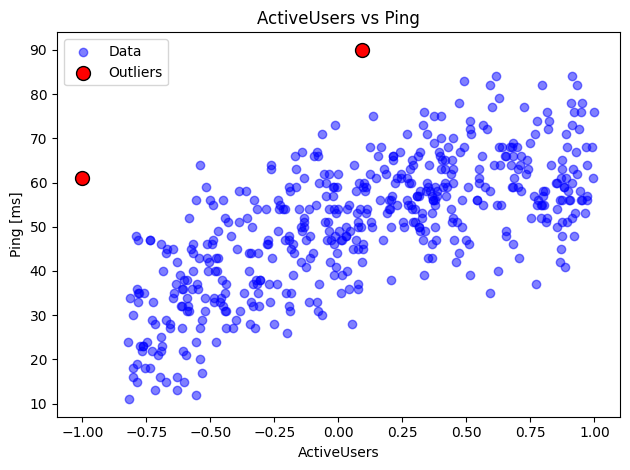

In [87]:
outliers = [255, 476]

# plt.figure(figsize=(10, 6))
plt.scatter(df['ActiveUsers'], df['Ping'], alpha=0.5, color='blue', label='Data')

plt.scatter(
    df.loc[outliers, 'ActiveUsers'], 
    df.loc[outliers, 'Ping'], 
    color='red', 
    label='Outliers', 
    s=100,
    edgecolors='black'
)

plt.title('ActiveUsers vs Ping')
plt.xlabel('ActiveUsers')
plt.ylabel('Ping [ms]')
plt.legend()

plt.tight_layout()
plt.show()

No, teď tedy přejdu k smazání těchto outlierů.
Zase si také vykreslím grafy, jako předtím, čistě pro kontrolu, že jsem nikde neudělal chybu.

A zjevně nic špatně není.
Graf reziduí je nyní již opravdu okolo nuly a obecný graf dat už neobsahuje zvýrazněné outliery, jako výše.
Vše tedy zjevně funguje.

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     349.9
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          1.28e-215
Time:                        20:56:08   Log-Likelihood:                -1528.7
No. Observations:                 500   AIC:                             3079.
Df Residuals:                     489   BIC:                             3126.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

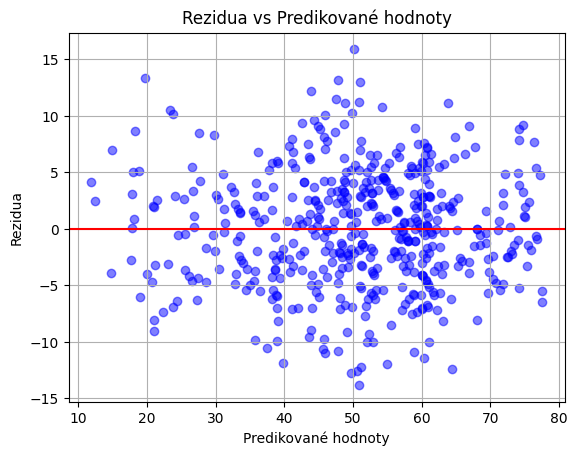

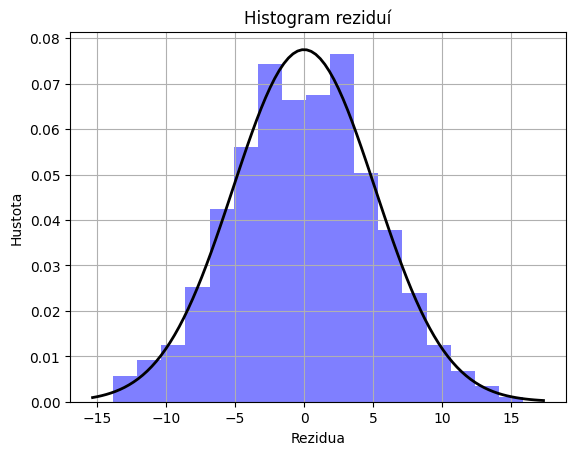

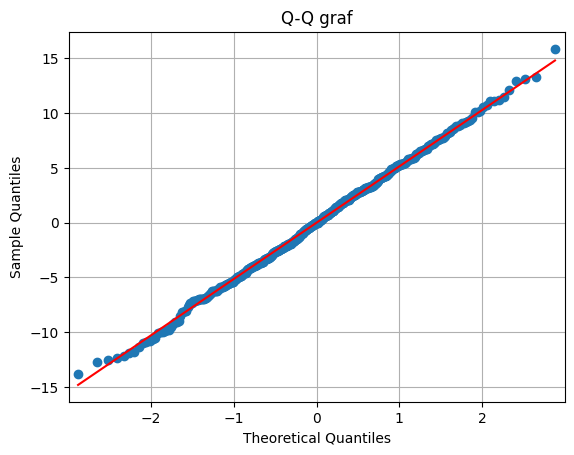

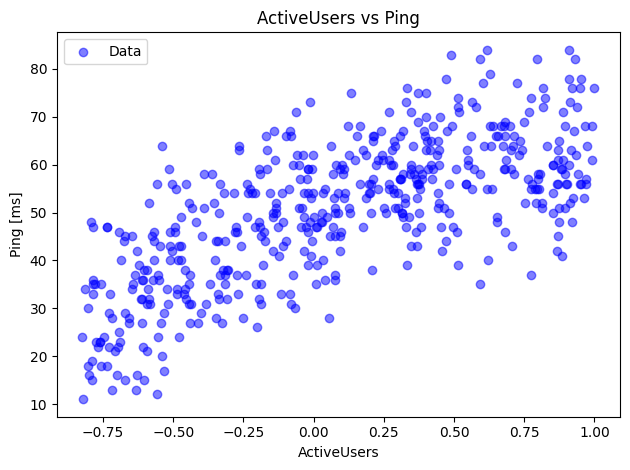

In [88]:
# vypustim outliery
df_final = df.drop(index=outliers)

# prepoctu model bez outlieru
result_final, model_final = evaluate_model(df_final, formula)

print(result_final.summary())

# GRAF REZIDUI VS PREDIKOVANE HODNOTY
plt.scatter(result_final.fittedvalues, result_final.resid, alpha=0.5, color='blue')

plt.axhline(y=0, color='r', linestyle='-') 
plt.grid(True)
plt.xlabel('Predikované hodnoty')
plt.ylabel('Rezidua')
plt.title('Rezidua vs Predikované hodnoty')
plt.show()

# HISTOGRAM REZIDUI
plt.hist(result_final.resid, bins='auto', color='blue', alpha=0.5, density=True)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(result_final.resid), np.std(result_final.resid))
plt.plot(x, p, 'k', linewidth=2)
plt.grid(True)
plt.title("Histogram reziduí")
plt.xlabel("Rezidua")
plt.ylabel("Hustota")
plt.show()

# Q-Q GRAF
qqplot(result_final.resid, line='s')
plt.title('Q-Q graf')
plt.grid(True)
plt.show()

# GRAFIK DAT BEZ OUTLIERU
plt.scatter(df_final['ActiveUsers'], df_final['Ping'], alpha=0.5, color='blue', label='Data')

plt.title('ActiveUsers vs Ping')
plt.xlabel('ActiveUsers')
plt.ylabel('Ping [ms]')
plt.legend()

plt.tight_layout()
plt.show()

Jako shrnutí je dobré zmínit, že jak jsem zmiňoval ve diskuzi v předchozím bodu, graf opravdu obsahoval outliery.
Těch jsem se úspěšně zbavil a nyní vypadá Q-Q graf a histogram reziduí výrazně lépe.
I Jarque-Berra test, který v předchozím bodu naznačoval, že by odlehlé hodnoty mohly být problém, již ukazuje, že rezidua víceméně odpovídají normálnímu rozdělení.

### 2.2

Pomocí Vašeho výsledného modelu identifikujte, pro které nastavení parametrů má odezva nejproblematičtější (největší) hodnotu (použijte model, nikoli samotná pozorování).

In [89]:
# opisu si rovnici modelu z vysledku prvniho bodu
def model_equation(params):
    active_users, interacting_pct, macos, windows, ios = params
    
    return - (
        + 40.2495
        + 24.4186 * active_users
        + 18.3647 * interacting_pct
        + 8.7999 * macos
        + 4.1936 * windows
        - 5.3112 * ios
        - 9.9907 * active_users**2
        - 15.1484 * active_users * interacting_pct
        + 6.9549 * active_users * macos
        - 3.6108 * active_users * windows
        - 5.0588 * active_users * ios
    )

# nastavim si pocatecni hodnoty na stred intervalu (neni to teda prumer hodnot, ale tak aspon cca)
# pouzil jsem totiz preskalovani na interval <-1; 1>
intial_guess = [0, 0, 0, 0, 1]

# nastavim si hranice, ve kterych se parametry muzou pohybovat (podle zvoleneho skalovani)
# MacOS, Windows, iOS jsou dummy promenne, takze ty jsou bud 0 nebo 1 (delal jsem to na zacatku tohoto ukolu)
bounds = [
    (-1, 1), # ActiveUsers
    (-1, 1), # InteractingPct
    (0, 1),  # MacOS
    (0, 1),  # Windows
    (0, 1)   # iOS
]

# nastavim si podminku, ze soucet MacOS, Windows a iOS musi byt 1
# muze tam byt max jeden z nich
# pokud jsou 0 vsichni, pak je to Android
constraints = [
    {'type': 'ineq', 'fun': lambda x: 1 - (x[2] + x[3] + x[4])}
]

# spustim optimalizaci (podobne jako v prvnim ukolu)
result2 = opt.minimize(model_equation, intial_guess, bounds=bounds, constraints=constraints)

# tady tohle mi da, jake jsou optimalni parametry
optimal_params = result2.x

# z tohodle zjistim, jaky je maximalni ping
max_ping = -result2.fun

# a nejak si to vypisu
print(f'Optimal parameters:')
print(f'\tActiveUsers: {round(optimal_params[0], 4)} => denormalized: ~ {round(denormalize_value(optimal_params[0]))}')
print(f'\tInteractingPct: {round(optimal_params[1], 4)}')
print(f'\tMacOS: {round(optimal_params[2])}')
print(f'\tWindows: {round(optimal_params[3])}')
print(f'\tiOS: {round(optimal_params[4])}')

print(f'\nMax ping: {round(max_ping, 4)}')

Optimal parameters:
	ActiveUsers: 0.812 => denormalized: ~ 9032
	InteractingPct: 1.0
	MacOS: 1
	Windows: 0
	iOS: 0

Max ping: 74.0016


### 2.3

Odhadněte hodnotu odezvy uživatele s Windows, při průměrném nastavení ostatních parametrů a vypočtěte konfidenční interval a predikční interval pro toto nastavení.

In [90]:
# z normalizovaneho dataframe si vytahnu mean pro ActiveUsers a InteractingPct
mean_active = df_final['ActiveUsers'].mean()
mean_interacting = df_final['InteractingPct'].mean()

# vytvorim si dataframe s prumernymi hodnotami
tmp_df_mean = pd.DataFrame({
    'ActiveUsers': [mean_active],
    'InteractingPct': [mean_interacting],
    'MacOS': [0],
    'Windows': [1],
    'iOS': [0],
})

# z predikce si vytahnu hodnoty
predicted_windows = result_final.get_prediction(tmp_df_mean)
# musim vlozit konfidencni interval
predicted_windows_summary = predicted_windows.summary_frame(0.05)

predicted_ping = predicted_windows_summary.iloc[0]['mean']

# vytahnu si konfidencni interval
ci_lower = predicted_windows_summary.iloc[0]['mean_ci_lower']
ci_upper = predicted_windows_summary.iloc[0]['mean_ci_upper']

# a vytahnu i predikcni interval
pi_lower = predicted_windows_summary.iloc[0]['obs_ci_lower']
pi_upper = predicted_windows_summary.iloc[0]['obs_ci_upper']

# a vypisu vysledky...
# predikovany ping
print(f'Predicted ping: {round(predicted_ping, 4)}')

# konfidencni interval
print(f'Confidence interval (95%): <{round(ci_lower, 4)}; {round(ci_upper, 4)}>')

# predikcni interval
print(f'Prediction interval (95%): <{round(pi_lower, 4)}; {round(pi_upper, 4)}>')

Predicted ping: 55.0027
Confidence interval (95%): <53.9721; 56.0332>
Prediction interval (95%): <44.7247; 65.2807>


### 2.4

Na základě jakýchkoli vypočtených charakteristik argumentujte, zdali je váš model "vhodný" pro další použití.

In [91]:
# vypisu si statistiky vysledku
print(result_final.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     349.9
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          1.28e-215
Time:                        20:56:09   Log-Likelihood:                -1528.7
No. Observations:                 500   AIC:                             3079.
Df Residuals:                     489   BIC:                             3126.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Jako první otázku, kterou bych se zabýval, je to, jestli mám dostačující množství pozorování.
Myslím si totiž, že by na "sociální síť" bylo potřeba výrazně více než 500 (bavil bych se asi v řádu mnoha tisíců, desetitisíců).
Určitě by bylo vhodné brát data nějak periodicky a obecně velmi často, na mých datech není poznat, jestli nejsou brána náhodně.
Na více testovacích datech bych také byl schopen na nějaké části regresní model natrénovat a na té další ho zvalidovat - tedy ověřit, že funguje správně.
Také je v jednotlivých pozorováních určitě málo uživatelů, Facebook nebo Twitter (atd. nevím, co všechno se dneska používá) v jednom momentě používají statisíce nebo miliony lidí současně.

Co se týče mých statistik, tak z pohledu na **R-squared** je na tom model poměrně dobře (má zhruba `87.7%`). To znamená, že model velmi slušně fituje data (byť by to samozřejmě mohlo být o kousek lepší).

Významnost mého modelu taky docela podporuje můj výsledek **F-statistiky**, která je velmi nízko (`1.28e-215`), což je velmi dobrá hodnota.

Když se podívám na vyhodnocení parametrů, nejvíc model ovlivňuje množství aktivních uživatelů (`coef = 29.3976`) a procento interagujících uživatelů (`coef = 18.8365`), což napovídá, že primárně tyto parametry hrají hlavní roli při zvyšování odezvy.
To i docela dává smysl, protože čím více uživatelů mám, tím víc mám zatížené servery nebo síť a tím pomaleji jsem schopný odpovídat.

Docela zajímavé je i se podívat na to, jaký vliv na ping mají různé operační systémy.
Největší vliv má Windows (`coef = 3.9905`) a MacOS (`coef = 8.2538`), více však Windows.
IOS má na ping spíše opačný efekt (`coef = -5.2566`).

Co se týče testů **Omnibus a Jarque-Berra**, tak u nich zde říct, že rezidua odpovídají normálnímu rozdělení, protože nejde zamítnout hypotézu, která u těchto testů říká, že *"rezidua odpovídají výběru z normálního rozdělení*.

**Durbin-Wattsonův test** (test autokorelace) je velmi blízko hodnotě 2 (`1.990`), což mi říká, že rezidua jsou mezi sebou nezávislá.

Ve zkratce bych to shrnul asi tak, že můj model vlastně není špatný a testy vycházejí velmi pěkně, nicméně bych měl trochu strach u malého počtu pozorování.
Určitě by jich to chtělo více, abych dotával bezpečnější (nebo trochu důvěryhodnější výsledky).